Работа с изображениями с целью аугментации.
    
1. Изображения, на которых автомобили есть или нет. 100 изображений целевого класса и 100 нецелевого. Размер 256x256px.
2. Библиотеки: OpenCV, pillow, scikit-image, tf.image. 
3. Аугментация (вращение, растяжение/сжатие, увеличение/уменьшение). Количество изображений должно увеличиться минимум в 3 раза.

In [1]:
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
# vs code не поддерживает input() в нотбуках...
base_path = '/home/anton/Документы/data_science_courses/cars_hw9_data/' # input()
test_image_path = os.path.join(base_path, 'vid_4_1000.jpg')

In [3]:
def show(image):
    cv2.imshow("image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

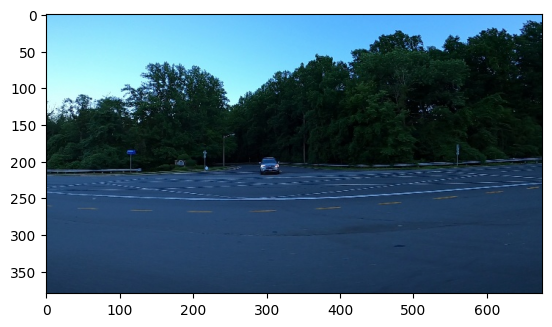

In [4]:
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [5]:
def resize_image(image, h, w):
    image = cv2.resize(image, (h, w), cv2.INTER_CUBIC)
    return image

In [6]:
class Augmentator:

    @staticmethod
    def augment(images, scale=3):
        res = []

        callchain = [Augmentator.__flip, Augmentator.__noise, Augmentator.__zoom, Augmentator.__rotate]

        for image in images:
            for it in range(scale):
                dst_image = image
                for link in callchain:
                    dst_image = link(dst_image)
                res.append(dst_image)
        
        return res
                

    @staticmethod
    def __rotate(image):
        angle = np.random.choice([0, 30, 60, 90, 270])
        h, w = image.shape[:2]
        rotation_mat = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
        return cv2.warpAffine(image, rotation_mat, (w, h))
    
    @staticmethod
    def __flip(image):
        flip_mode = np.random.choice([-1, 0, 1])
        if flip_mode != -1:
            return cv2.flip(image, flip_mode)
        return image
    
    @staticmethod
    def __noise(image):
        if np.random.choice([True, False]):
            return skimage.util.random_noise(image)
        return image

    @staticmethod
    def __zoom(image):
        zoom_lvl = np.random.choice([0.25, 0.5, 0.75, 1.0])
        h, w = image.shape[:2]

        new_h = int(zoom_lvl * h)
        new_w = int(zoom_lvl * w)

        h_start = random.randint(0, h - new_h)
        w_start = random.randint(0, w - new_w)

        zoomed_image = image[h_start:h_start + new_h, w_start:w_start + new_w]
        zoomed_image = resize_image(zoomed_image, h, w)

        return zoomed_image



In [7]:
augmented = Augmentator.augment([img])

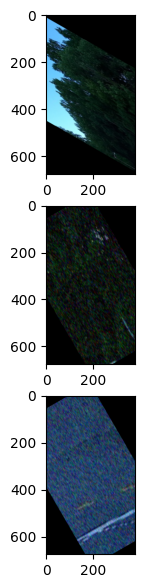

In [8]:
fig = plt.figure(figsize=(10, 7))
rows = len(augmented)
cols = 1
for i, image in enumerate(augmented):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image)

In [9]:
import requests
import zipfile

In [10]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [11]:
file_id = "18ZHqBzfn_GbedNI3Tk1fMZ7fp4tbuO4q"
output = "data.zip"
download_file_from_google_drive(file_id, output)

In [12]:
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('data')

In [13]:
images = [resize_image(cv2.imread(os.path.join('data', image_path)), 256, 256) for image_path in os.listdir('data')]
print("Src size: ", len(images))
images = Augmentator.augment(images)
print("Dst size: ", len(images))

Src size:  200
Dst size:  600


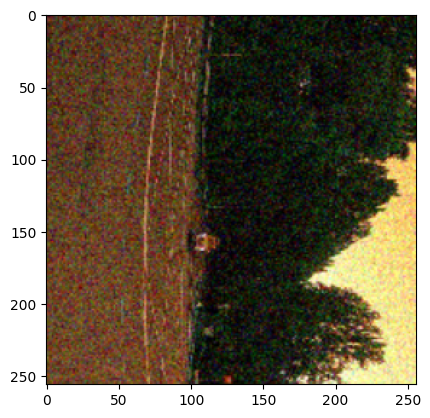

In [14]:
dst_path = 'augmented'
os.mkdir(dst_path)

plt.imshow(images[0])
for i, image in enumerate(images):
    cv2.imwrite(os.path.join(dst_path, f"{i}.jpg"), image)